## 🔧 Code guidelines:
- Please follow python coding convention "e.g. imports are alphabetically sorted".
- Use python type hinting for increased readability of your code.
- Please add any helper functions in the helper functions block.
- It is preferred to implement one-time-local-helper-functions inside your parent function.

## 🦦 Managing virtual environments:
```Console
*** Mac:
$ python3 -m venv venv
$ source venv/bin/activate
$ pip3 install -r requirements.txt
$ pip3 freeze > requirements.txt 
$ deactivate

*** Mac:
$ python -m venv venv
$ venv\Scripts\activate.bat
$ pip install -r requirements.txt
$ pip freeze > requirements.txt 
$ deactivate
```

In [115]:
import cv2
import os, csv
import imutils
import matplotlib.pyplot as plt
import numpy as np
import skimage as sk
import skimage.measure
from skimage.morphology import binary_erosion
from typing import Final


In [116]:
# Extra Import

import warnings

warnings.filterwarnings('ignore')

# Helper Functions

In [143]:
# [0]: Add helper functions here
def show_images(images, titles=None):
    """Display a list of images in a single figure with matplotlib."""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images,titles), start=1):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        # plt.axis('off')
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

# Crop Number Plate

In [118]:
# [1]: Crop Number Plate
def crop_image(image: np.ndarray): #-> np.ndarray:
    # [0]: Local CONSTANTS
    CANNY_THRESH_LOW: Final[int] = 170
    CANNY_THRESH_HIGH: Final[int] = 200
    BILATERAL_FILTER_SIZE: Final[int] = 11
    BILATERAL_FILTER_SIGMA_COLOR: Final[int] = 17
    BILATERAL_FILTER_SIGMA_SPACE: Final[int] = 17
    MAX_NUM_CONTOURS: Final[int] = 30
    # [1]: Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # [2]: Reduce noise and preserve edges
    gray = cv2.bilateralFilter(
        gray, 
        BILATERAL_FILTER_SIZE, 
        BILATERAL_FILTER_SIGMA_COLOR, 
        BILATERAL_FILTER_SIGMA_SPACE
    )
    # [3]: Edge Detection
    edges = cv2.Canny(gray, CANNY_THRESH_LOW, CANNY_THRESH_HIGH)
    # [4]: Find contours && sort by their area
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:MAX_NUM_CONTOURS]
    # [5]: Find contour with 4 corners
    def get_image(contour) -> np.ndarray:
        x, y, w, h = cv2.boundingRect(contour)
        return gray[y:y+h, x:x+w]
    temp=[
        get_image(c)
        for c in contours 
        if cv2.approxPolyDP(c, 0.01 * cv2.arcLength(c, True), True).shape[0] == 4
    ]
    return temp[0] if temp else []

# Rotate Image

In [119]:
# [2]: Skew Rotation Correction
def rotate_image(image: np.ndarray) -> np.ndarray:
    # [0]: Local CONSTANTS
    CANNY_THRESH_LOW: Final[int] = 0
    CANNY_THRESH_HIGH: Final[int] = 100
    # [2]: Edge Detection
    edges = cv2.Canny(image, CANNY_THRESH_LOW, CANNY_THRESH_HIGH)
    # [3]: Hough Transform
    lines = cv2.HoughLines(edges, 1, np.pi/180, 40)
    # [4]: Find most common angle
    angle = np.degrees(max(
        (line[0][1] for line in lines), 
        key=lambda x: list(lines[:,0,1]).count(x)
    ))
    # [5]: Rotate the image
    return sk.transform.rotate(
        image,
        angle+90 if angle<0 else angle-90
    )

# Character Segmentation

In [231]:
# [3]: Character Segmentation
def segment_Character(image: np.ndarray) -> np.ndarray:
    Height,Width=image.shape
    # print(Height,Width)
    image_out = np.zeros(image.shape)
    # [1]: Threshold Image using OTSU for automatic thresholding
    Threshold = sk.filters.threshold_otsu(image)
    image_out[image <= Threshold] = 1
    # show_images([ image_out])

    # [2]: Detect Contours around each character
    contours = sk.measure.find_contours(image_out, 0.8)
    bounding_boxes = []
    for contour in contours:
        startY, endY = min(contour[:, 0]), max(contour[:, 0])
        startX, endX = min(contour[:, 1]), max(contour[:, 1])
        ratio = (endY-startY)/(endX-startX)
        if(1 < ratio < 3.5):
            tup = map(int, np.round((startX, endX, startY, endY)))
            # print(startY,endY,"Height",endY-startY,startX, endX,"Width",endX-startX)
            # bounding_boxes.append(tuple(tup))
            endY-startY > (0.25*Height) and endX - \
                startX > (0.01*Width) and bounding_boxes.append(tuple(tup))
            # endY-startY > (0.3*Height) and endX - \
            #     startX > (0.01*Width) and print(endY,startY,"Height",endY-startY, endX,startX,"Width",endX-startX)

    # [3]: Sort the boundring boxes to make sure that the characters are drawin in the right order
    bounding_boxes = sorted(bounding_boxes, key=lambda x: x[0])
    # print(bounding_boxes)
    # [FIX]: avoid overlapping of contours
    accurate_bounding_box=[]
    old_endX=0
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        if (Xmin>old_endX):
            accurate_bounding_box.append(box)
            old_endX=Xmax
            
    bounding_boxes=accurate_bounding_box
    # print(bounding_boxes)
    # [4] : Draw a Box surrounding the character
    img_with_boxes = np.copy(image)  # np.zeros(image.shape)
    # When provided with the correct format of the list of bounding_boxes, this section will set all pixels inside boxes in img_with_boxes
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        rr, cc = sk.draw.rectangle_perimeter(
            start=(Ymin, Xmin), end=(Ymax, Xmax), shape=image.shape)
        img_with_boxes[rr, cc] = 0  # set color Black
    Xmin, Xmax, Ymin, Ymax = bounding_boxes[1]
    # show_images([img_with_boxes])
    # [5]: create a list of images cropped images for each character
    character_Image_list = []
    CHARACTER_PADDING_X: Final[int] = 2
    CHARACTER_PADDING_Y: Final[int] = 2
    for box in bounding_boxes:
        character = image_out[box[2]-CHARACTER_PADDING_Y:box[3] +
                              CHARACTER_PADDING_Y, box[0]-CHARACTER_PADDING_X:box[1]+CHARACTER_PADDING_X]
        character_Image_list.append(character)

    # show_images(character_Image_list)
    for i in range(len(character_Image_list)):
        plt.subplot(1, len(character_Image_list), i+1)
        plt.imshow(character_Image_list[i], cmap='gray')
        plt.axis('off')
    plt.show()

    # ---> List of boxes for each character
    return character_Image_list


# Character Recognition | Template Matching

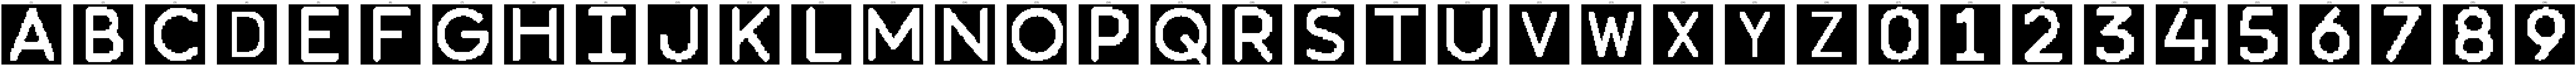

In [121]:
# Get Characters
import os
import skimage.io

Characters = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

CharTemplate = []

# read all files in template folder and store them in CharTemplate
for index, char in enumerate(Characters):
    CharTemplate.append((sk.io.imread('templates/'+char+'.jpg') > 200).astype(np.uint8)*255)
show_images(CharTemplate)


In [122]:
# [4]: Character reconigtion

def calculateTheEuclideanDistance(image1, image2):
    # sum of absolute differences between the pixels of the two images
    return np.linalg.norm(image1.flatten()-image2.flatten())

def calculateTheCrossCorrelation(image1, image2):
    # Calculate the cross correlation between two images
    # The cross correlation is the sum of the product of the pixels of the two images
    return np.sum(image1*image2)

def calculateTheNormalizedCrossCorrelation(image1, image2):
    # Calculate the normalized cross correlation between two images
    # The normalized cross correlation is the sum of the product of the pixels of the two images divided by the product of the standard deviations of the two images
    return np.sum(image1*image2)/(np.std(image1)*np.std(image2))

def getMaxIndex(list):
    max = 0
    index = 0
    for i in range(len(list)):
        if list[i] > max:
            max = list[i]
            index = i
    return index

def characterRecognition (license):
    text = ''
    
    for charac in license:
        # resize image
        charac= charac.astype(np.int8)*255
        charac = sk.transform.resize(charac, (48, 48))
        charac = (charac*255).astype(np.int8)

        templateMatchingValues = []

        for i in range (len(CharTemplate)):
            crossCorrelation = calculateTheCrossCorrelation(charac, CharTemplate[i])
            euclideanDistance = calculateTheEuclideanDistance(CharTemplate[i],charac)
            normalizedCrossCorrelation = calculateTheNormalizedCrossCorrelation(CharTemplate[i],charac)
            templateMatchingValues.append(crossCorrelation/(euclideanDistance + normalizedCrossCorrelation) )
        text += Characters[getMaxIndex(templateMatchingValues)]

    return text
    

# CharacterRecognition | KNN

### Imports 


In [123]:

import numpy as np

import matplotlib.pyplot as plt

import cv2 as cv

import os
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from Levenshtein import distance as lev

## Import Dataset

In [124]:
# dir_path = 'CNN letter Dataset'
dir_path = 'Train'
digits = sorted(os.listdir(dir_path))
digitLetter=[digit[-1] for digit in digits]
NUM_CLASSES = len(digits)

print(digits)
print('Number of classes (letters and digits): ', NUM_CLASSES)

digits_counter = {}
NUM_IMAGES = 0

for digit in digits:
    path = os.path.join(dir_path, digit)
    digits_counter[digit] = len(os.listdir(path))
    NUM_IMAGES += len(os.listdir(path))

print(digits_counter)
print('Number of all images: ', NUM_IMAGES)

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_A', 'class_B', 'class_C', 'class_D', 'class_E', 'class_F', 'class_G', 'class_H', 'class_I', 'class_J', 'class_K', 'class_L', 'class_M', 'class_N', 'class_O', 'class_P', 'class_Q', 'class_R', 'class_S', 'class_T', 'class_U', 'class_V', 'class_W', 'class_X', 'class_Y', 'class_Z']
Number of classes (letters and digits):  36
{'class_0': 24, 'class_1': 24, 'class_2': 24, 'class_3': 24, 'class_4': 24, 'class_5': 24, 'class_6': 24, 'class_7': 24, 'class_8': 24, 'class_9': 24, 'class_A': 24, 'class_B': 24, 'class_C': 24, 'class_D': 24, 'class_E': 24, 'class_F': 24, 'class_G': 24, 'class_H': 24, 'class_I': 24, 'class_J': 24, 'class_K': 24, 'class_L': 24, 'class_M': 24, 'class_N': 24, 'class_O': 24, 'class_P': 24, 'class_Q': 24, 'class_R': 24, 'class_S': 24, 'class_T': 24, 'class_U': 24, 'class_V': 24, 'class_W': 24, 'class_X': 24, 'class_Y': 24, 'class_Z': 24}
Number of all imag

### Check Sample of TestData

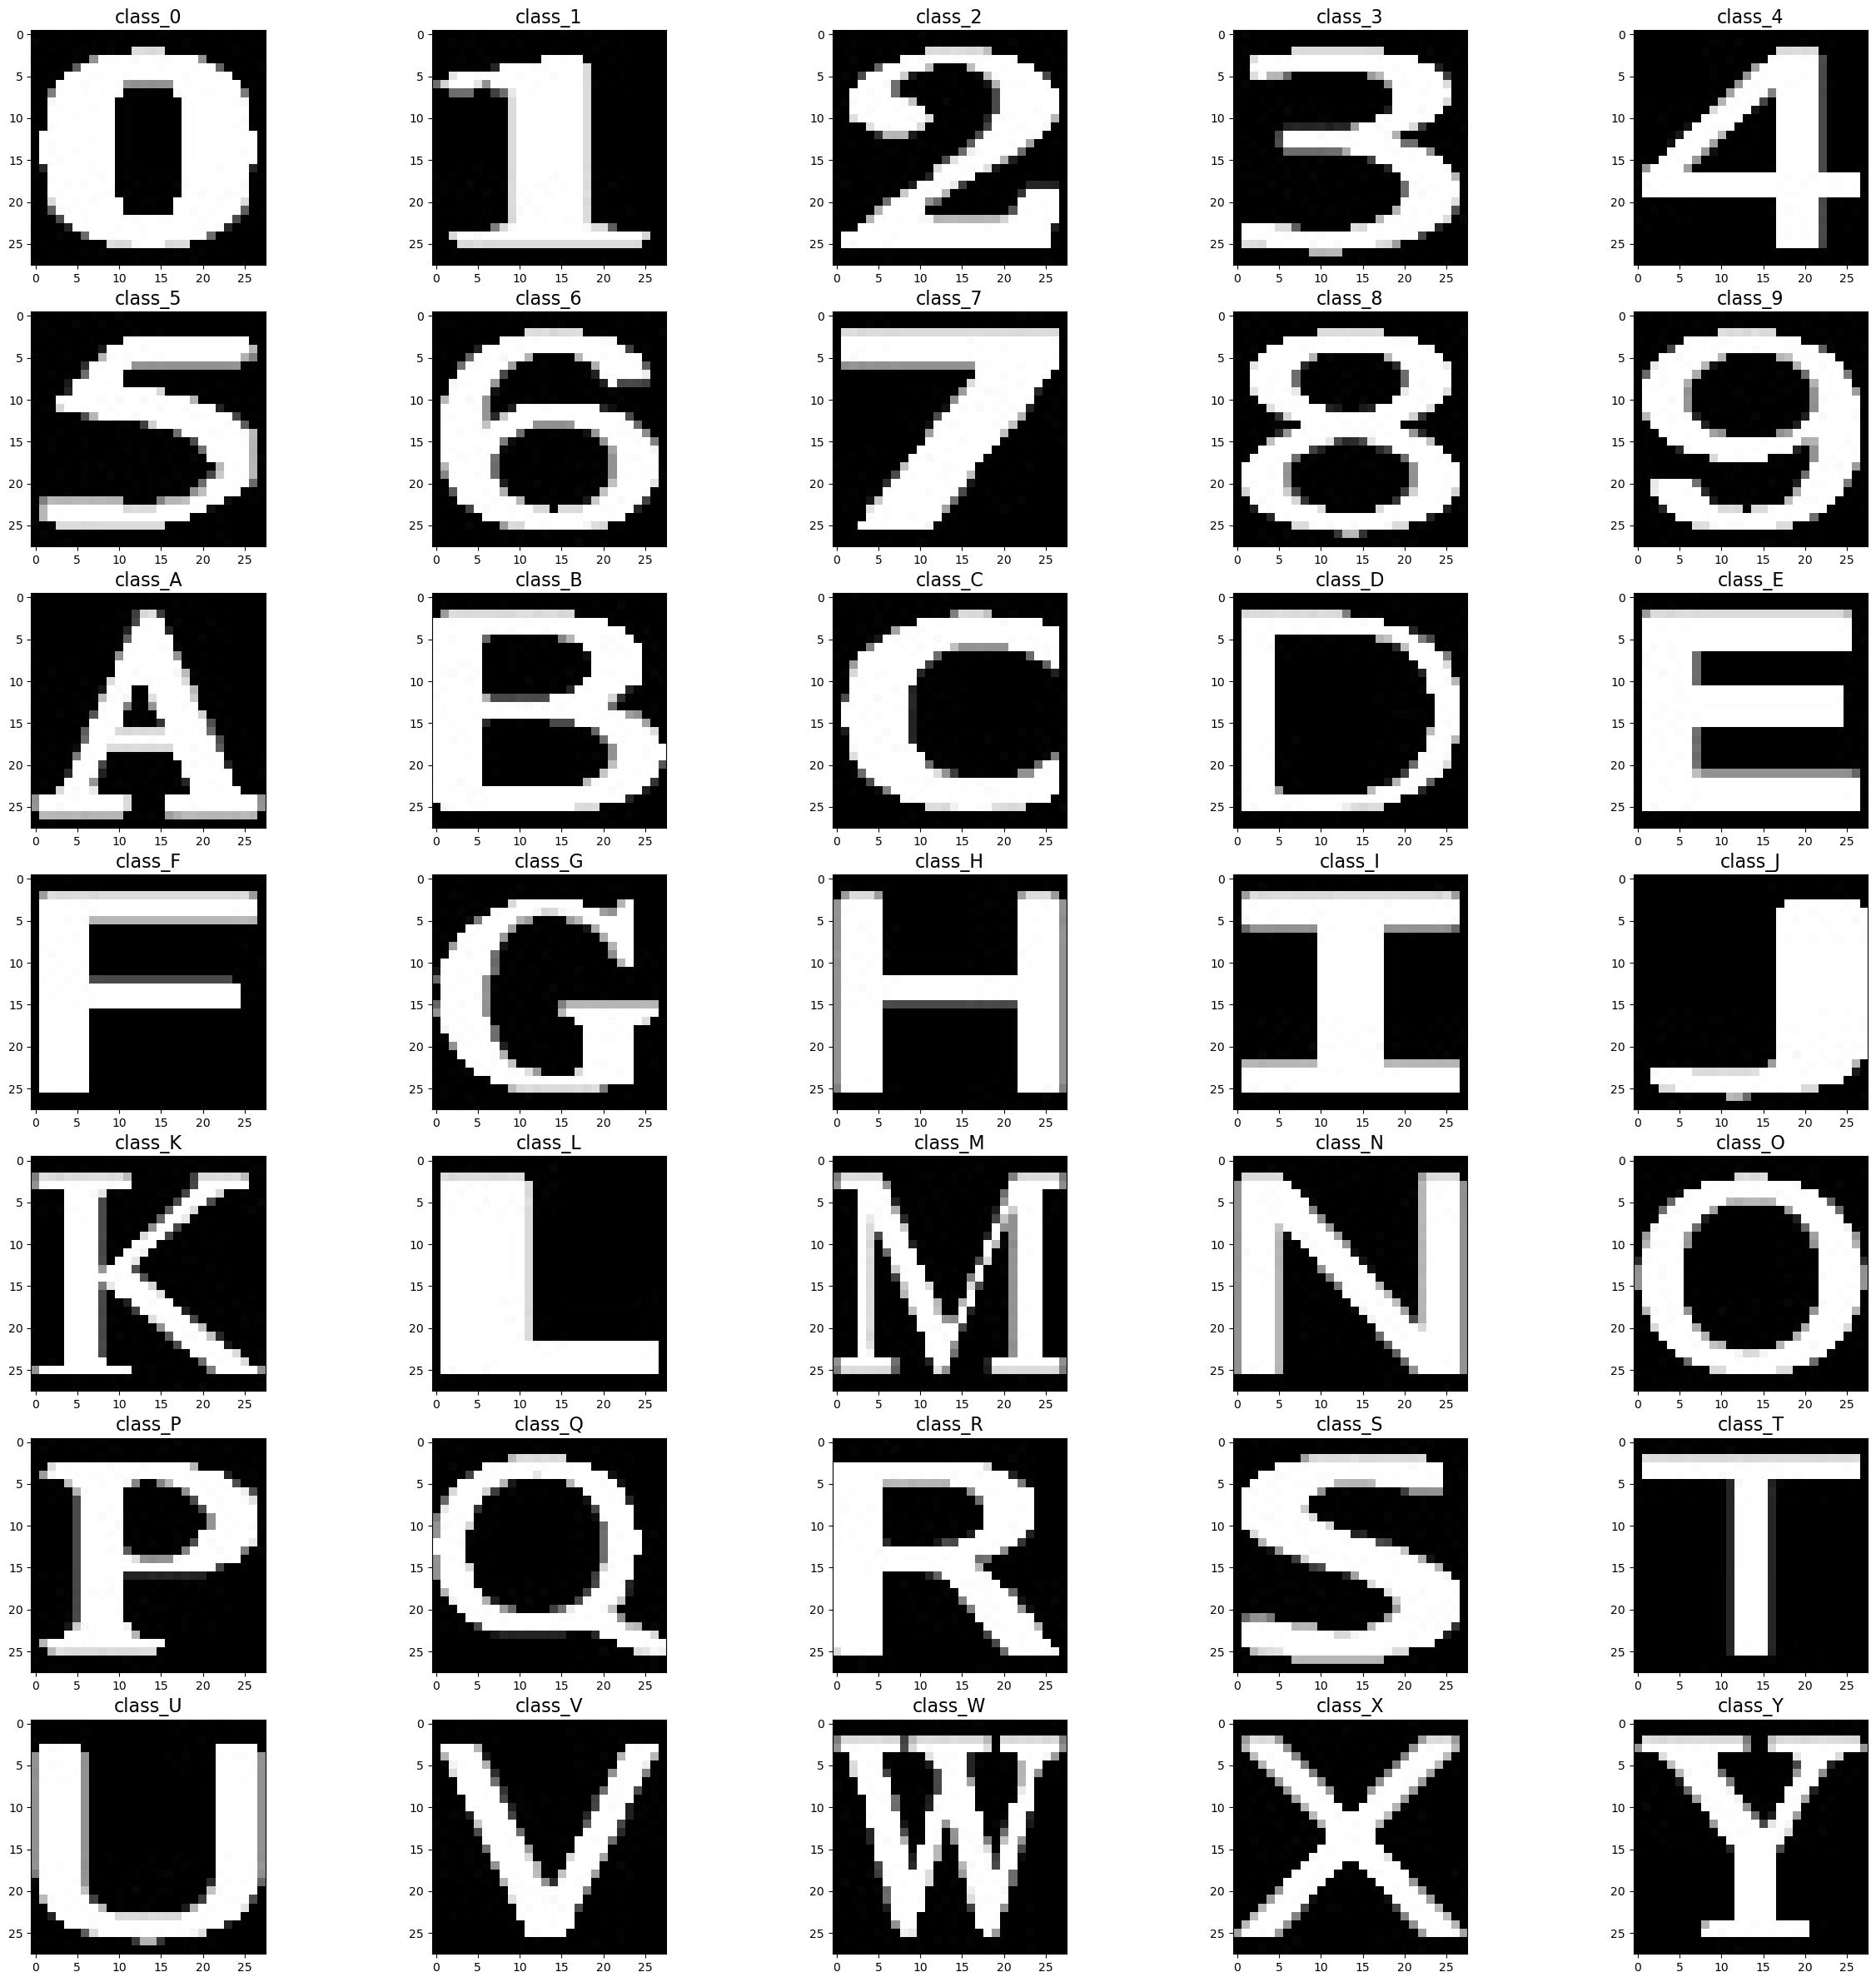

In [125]:
rows, columns = 7, 5

k = 0
fig, axes = plt.subplots(rows, columns, figsize=(30, 30))
for row in range(rows):
    for column in range(columns):
        rand_num = np.random.randint(0, digits_counter[digits[k]])
        class_path = dir_path + '/' + str(digits[k])
        image_path = class_path + '/' + str(os.listdir(class_path)[rand_num])
        ax = axes[row, column]
        ax.set_title(digits[k], loc='center', fontsize=16)
        ax.imshow(imread(image_path), cmap='gray')
        k += 1
plt.show()

### Prep For Train

In [126]:
data = []
labels = []
MAX_NUM = None   # maximum number of digits images per class
IMG_WIDTH, IMG_HEIGHT = 35, 45

# images of digits '6' in folder with '2'
incorrect_img = [
    'aug20121_0.jpg',
    'aug20122_1.jpg',
    'aug20123_2.jpg',
    'aug20124_3.jpg',
    'aug20125_4.jpg',
    'aug20126_5.jpg',
    'aug20127_6.jpg',
    'aug20128_7.jpg',
    'aug20129_8.jpg',
    'aug20130_9.jpg'
]

for digit in digits:
    path = os.path.join(dir_path, digit)
    label = digits.index(digit)
    for img in os.listdir(path):
        if img in incorrect_img:
            continue
        img_path = os.path.join(path, img)
        img_array = cv.imread(img_path)
        resized = cv.resize(img_array, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv.INTER_AREA)
        gray = cv.cvtColor(resized, cv.COLOR_RGB2GRAY)        
        data.append(gray)
        labels.append(label)
        if MAX_NUM is not None:
            if labels.count(label) == MAX_NUM:
                break

data = np.array(data, dtype='float32')
labels = np.array(labels, dtype='int8')
print(data.shape)


(864, 45, 35)


In [127]:

data = data / 255.0
# data = data.reshape(*data.shape, 1)
print(data.shape)
print(labels.shape)

(864, 45, 35)
(864,)


## Split DataSet

In [128]:

from sklearn.model_selection import train_test_split
nsamples, nx, ny = data.shape
d2_train_dataset = data.reshape((nsamples,nx*ny))

X_train, X_test, y_train, y_test = train_test_split(d2_train_dataset, labels, test_size=0.25)



## Train Model

In [241]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
# create an instance of the classifier
knn_default = KNeighborsClassifier(n_neighbors=3)
# fit the model and perform cross validation
knn_default.fit(X_train, y_train)
cv_scores = cross_val_score(knn_default, X_train, y_train, cv=5, scoring="accuracy")
# take the average of the scores of different folds
knn_default.fit(X_train, y_train)  
final_score_default = np.mean(cv_scores)
print("Accuracy with defaul KNN:", final_score_default)


Accuracy with defaul KNN: 0.9521407274895646


# Testing

### First Basic Tests

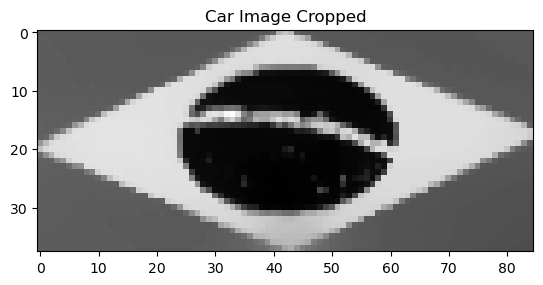

IndexError: list index out of range

In [270]:
car1_image = cv2.imread('./test_dataset/images/87.jpg')
# car2_image = cv2.imread('./test_dataset/images/87.jpg')
# car3_image = cv2.imread('./test_dataset/images/108.jpg')
cars=[car1_image]
#show_images(cars, ["Input Image1","Input Image2","Input Image"])

cars_image_cropped = [crop_image(car) for car in cars]
show_images(cars_image_cropped, ["Car Image Cropped","Car Image Cropped","Car Image Cropped"])

# car_image_rotated = [rotate_image(car) for car in cars_image_cropped]
# show_images(car_image_rotated, ["Car Image Rotated","Car Image Not Rotated","Car Image Rotated2"])

chars = [segment_Character(car) for car in cars_image_cropped]
# for i in range(len(chars)): show_images(chars[i])
test0=chars[0]


# show_images(test0)

# for i in range(len(chars)): print(characterRecognition(chars[i]))


### Test KNN of Specific Image

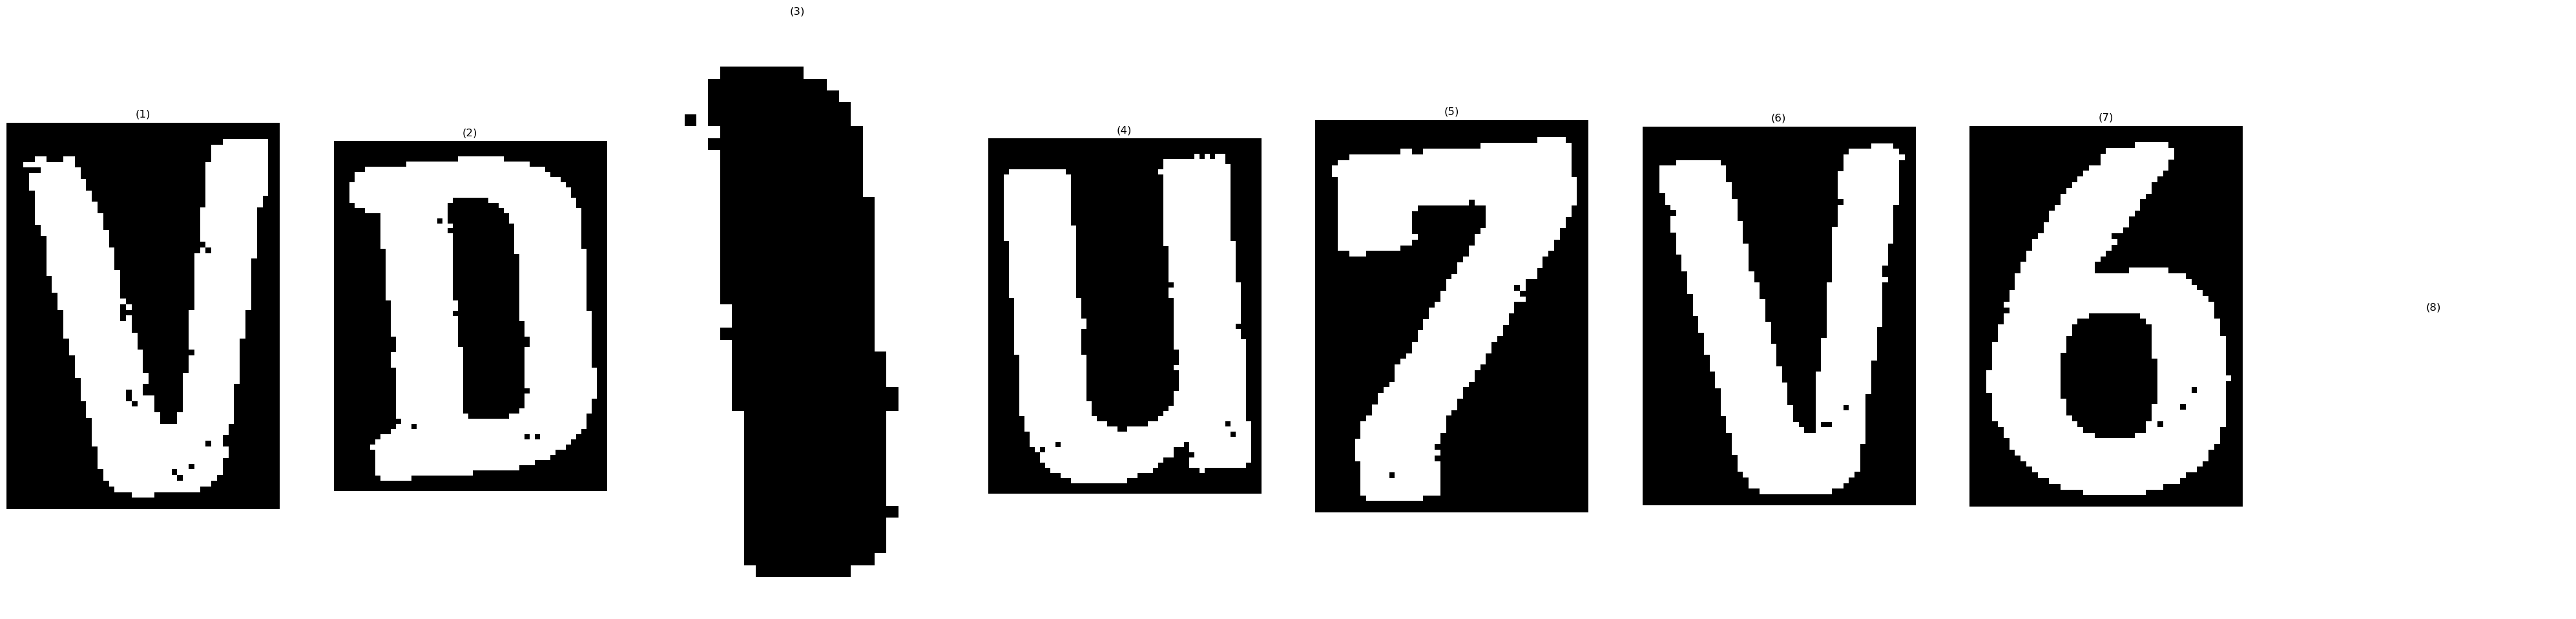

error: OpenCV(4.6.0) C:\b\abs_74oeeuevib\croots\recipe\opencv-suite_1664548340488\work\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [132]:

data2=""
show_images(test0)
for img in test0:
    # print(img)
    new_img = cv.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv.INTER_AREA)
    new_img = new_img.reshape((1,IMG_WIDTH*IMG_HEIGHT))
    # print(new_img.shape)
    y_prediction = knn_default.predict(new_img)
    # print(digitLetter[int(y_prediction)])
    data2+=digitLetter[int(y_prediction)]
print(data2)
# for i in range(len(chars)): show_images(chars[i])
# accuracy=np.mean(y_prediction == y_test)*100
# print("The achieved accuracy using Decision Tree is " + str(accuracy))

### Read Test Data

In [195]:
# read the test data to test from csv file
with open('test_dataset\labels.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    test_plates={}
    next(reader)
    for row in reader:
        test_plates[row[0]]=row[1] 
        
# print(test_plates)

In [277]:
for path, dirs, files in os.walk("test_dataset/images/"):
    car_names=[]
    for filename in files:
        car_names.append(filename)
car_names=sorted(car_names, key=lambda x: int(x[:-4]))
# print(car_names)    

# print(test_plates[car_names[0][:-4]],len(car_names))

cars={car[:-4]:car for car in car_names}
# cars ={ car:filename for car,filename in cars.items() if(int(car)<=183)  }
print(cars)

{'1': '1.jpg', '2': '2.jpg', '3': '3.jpg', '4': '4.jpg', '6': '6.jpg', '7': '7.jpg', '8': '8.jpg', '9': '9.jpg', '10': '10.jpg', '12': '12.jpg', '13': '13.jpg', '14': '14.jpg', '15': '15.JPG', '16': '16.jpg', '17': '17.jpg', '19': '19.jpg', '20': '20.jpg', '21': '21.jpg', '24': '24.JPG', '27': '27.JPG', '28': '28.JPG', '30': '30.JPG', '31': '31.JPG', '32': '32.JPG', '33': '33.JPG', '34': '34.JPG', '35': '35.JPG', '36': '36.JPG', '37': '37.JPG', '38': '38.JPG', '39': '39.JPG', '42': '42.JPG', '44': '44.JPG', '46': '46.JPG', '47': '47.JPG', '48': '48.JPG', '49': '49.JPG', '50': '50.JPG', '51': '51.JPG', '52': '52.JPG', '54': '54.JPG', '55': '55.JPG', '56': '56.JPG', '57': '57.JPG', '58': '58.JPG', '59': '59.JPG', '60': '60.JPG', '61': '61.JPG', '62': '62.JPG', '63': '63.JPG', '64': '64.JPG', '66': '66.JPG', '68': '68.JPG', '69': '69.JPG', '70': '70.JPG', '72': '72.jpg', '73': '73.jpg', '74': '74.jpg', '75': '75.jpg', '76': '76.JPG', '77': '77.jpg', '78': '78.jpg', '79': '79.jpg', '80': '

### Test the Test Data

In [278]:

#  '10.jpg','15.JPG','48.JPG','50.JPG','51.JPG','78.jpg','89.JPG','90.JPG','19.jpg','30.JPG', '62.JPG', '64.JPG','66.JPG','77.jpg','79.jpg','87.JPG','108.JPG'
ignoreFromCropp=['80.jpg','90.JPG']
# '19.jpg','30.JPG', '62.JPG','64.JPG','66.JPG','77.jpg','79.jpg','87.JPG','108.JPG','110.JPG','112.JPG','117.JPG' 

1.jpg


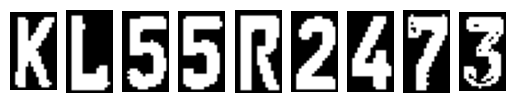

KL55R2473
2.jpg


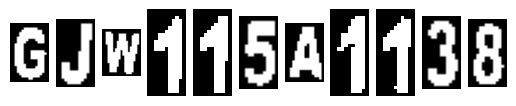

0JW115A1138
3.jpg


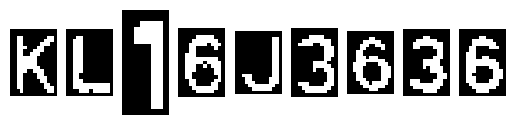

KL16J3636
4.jpg


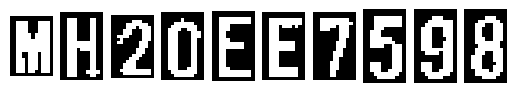

8H2DEF7598
6.jpg


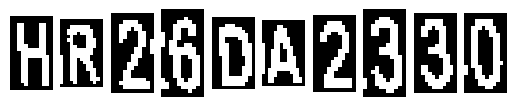

BR23DA2330
7.jpg


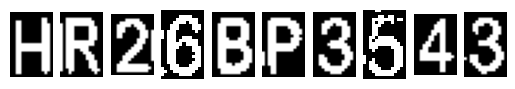

HR268P3643
8.jpg


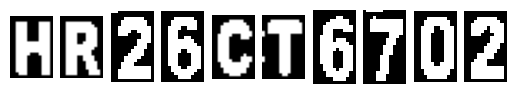

BR26CT67D2
9.jpg


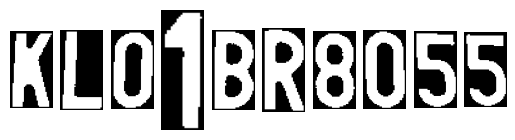

KL018R8055
10.jpg


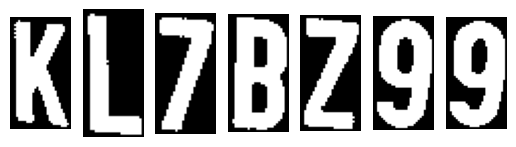

KL78Z99
12.jpg


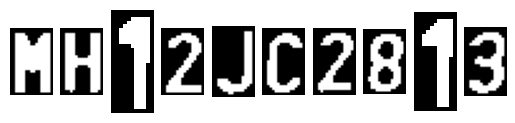

HH12JC2813
13.jpg


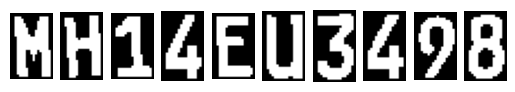

BB14EU3498
15.JPG


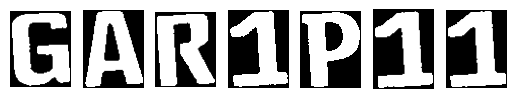

6AR1P11
19.jpg
21.jpg


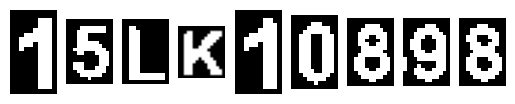

15LK1D898
28.JPG


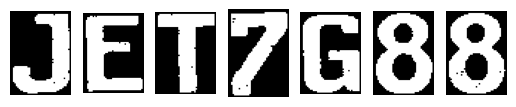

JLT7G88
30.JPG
31.JPG


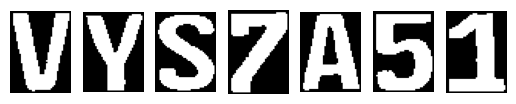

VY57A51
32.JPG


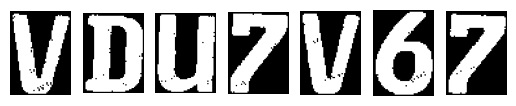

VBU7V67
34.JPG


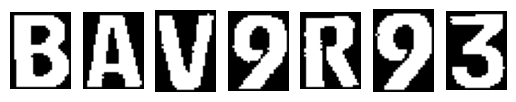

8AV9R93
35.JPG


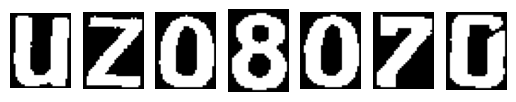

UZ08070
36.JPG


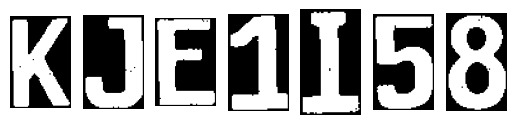

KJL2I58
39.JPG


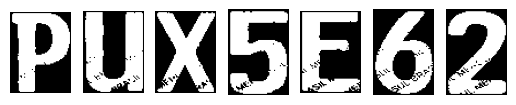

PUX5L62
42.JPG


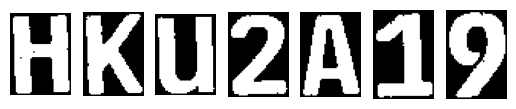

HKU2A29
44.JPG


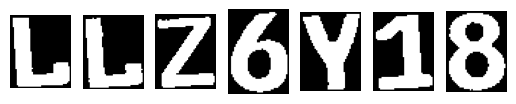

LLZ6Y18
47.JPG


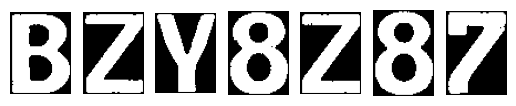

BZY8Z87
48.JPG


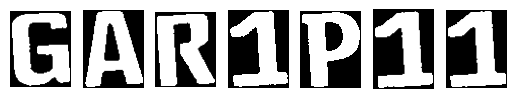

6AR1P11
50.JPG


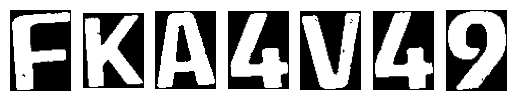

FKAAVA9
51.JPG


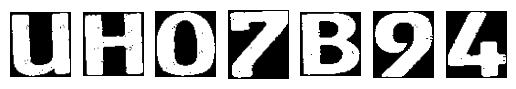

UH07B9A
54.JPG


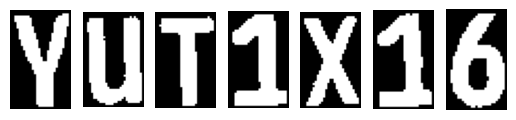

YUT2X26
55.JPG


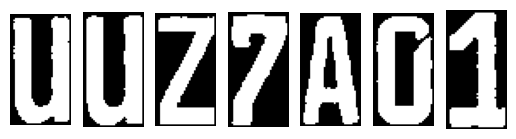

UUZ7AB2
56.JPG


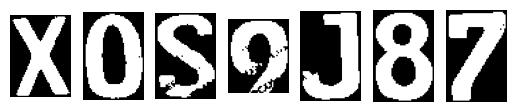

X0S0J87
57.JPG


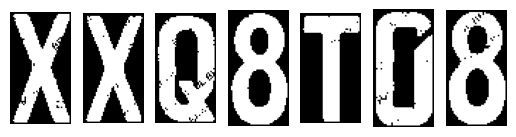

XX08TU8
58.JPG


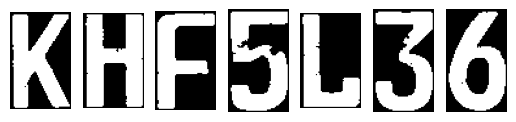

KHF5L36
61.JPG


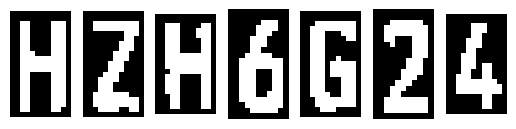

HZB6624
62.JPG
64.JPG
66.JPG
68.JPG


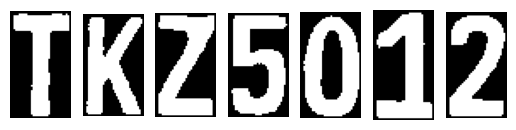

TKZ5022
69.JPG


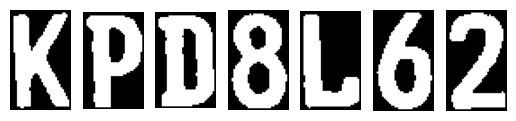

KPB8L62
72.jpg


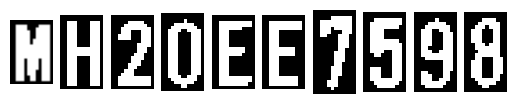

MB2DEE7598
73.jpg


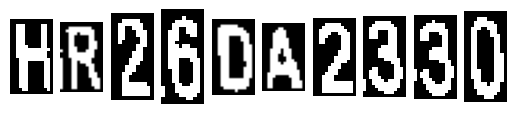

BR2BDA2330
74.jpg


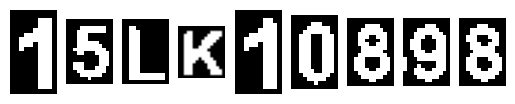

15LK1D898
75.jpg


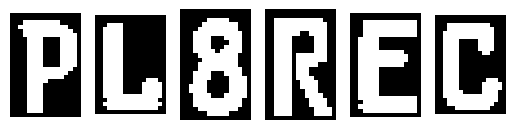

PL8REC
76.JPG


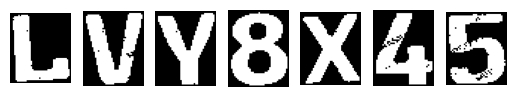

LVV8XA5
77.jpg
78.jpg


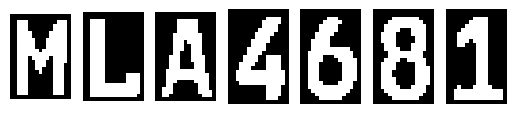

HLA4681
79.jpg
81.jpg


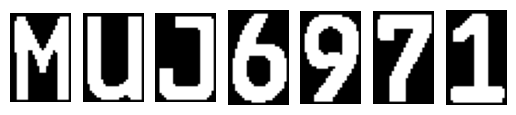

MUJ6971
82.jpg


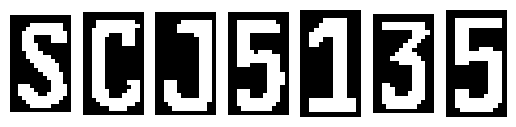

SCJ5J35
83.jpg


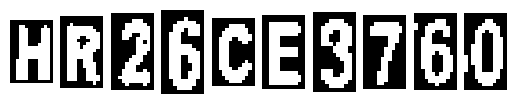

BR26CF376D
85.png


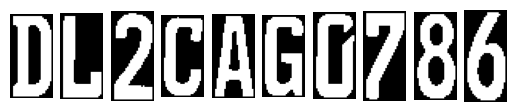

BL2CA6B786
87.JPG
89.JPG


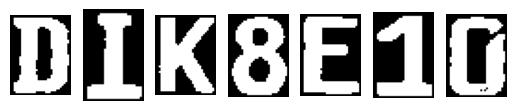

BIK8E20
94.jpg


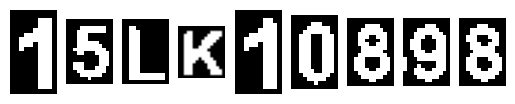

15LK1D898
95.JPG


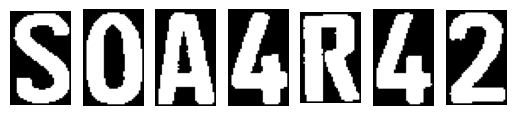

S0AARA2
96.JPG


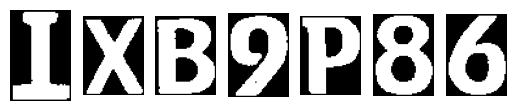

IXB9P86
99.JPG


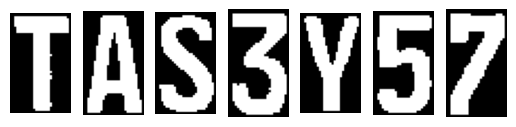

TAS3Y57
108.JPG
109.JPG


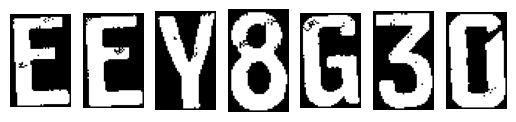

LEY8630
110.JPG
112.JPG
116.JPG


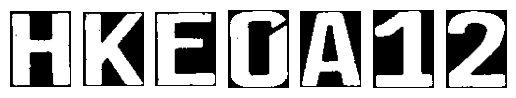

HKEUA22
117.JPG
118.JPG


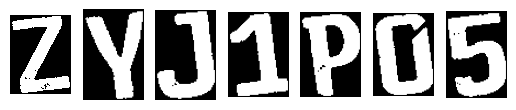

ZYJ1PB5
119.JPG


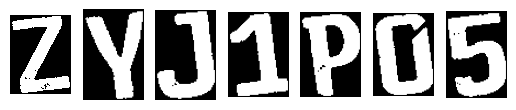

ZYJ1PB5
121.JPG
122.JPG
123.JPG
125.JPG
126.JPG
127.JPG
130.JPG


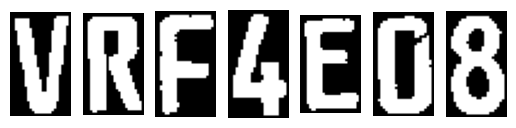

VRFAE08
142.JPG


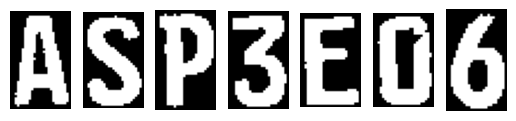

ASP3E06
143.JPG


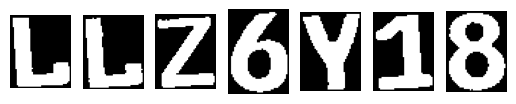

LLZ6Y18
146.JPG


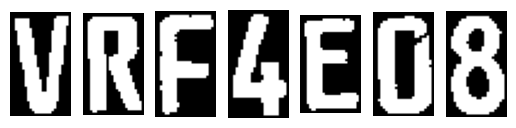

VRFAE08
147.JPG


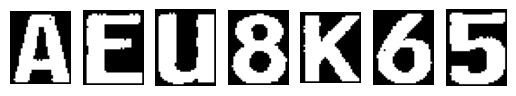

AEU8K65
148.JPG


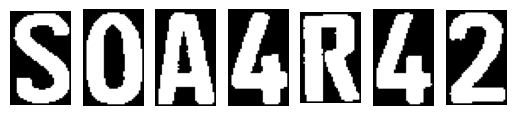

S0AARA2
150.JPG


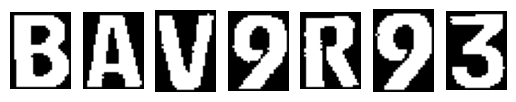

8AV9R93
154.JPG


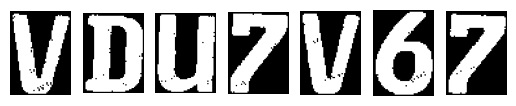

VBU7V67
155.JPG


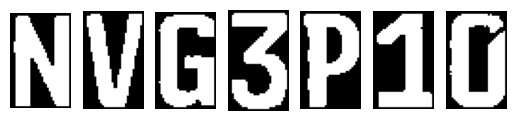

NVG3P20
156.JPG


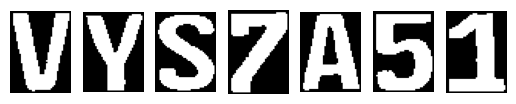

VY57A51
157.JPG


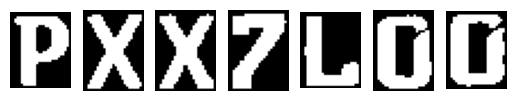

PXX7L0B
161.JPG


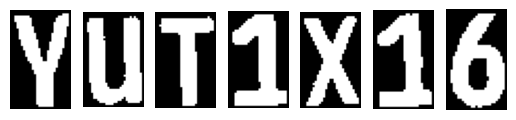

YUT2X26
162.JPG


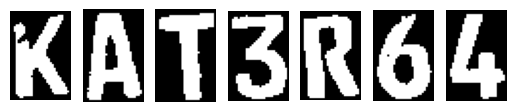

KAT3R6A
171.JPG


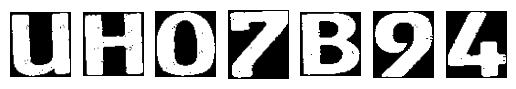

UH07B9A
175.JPG


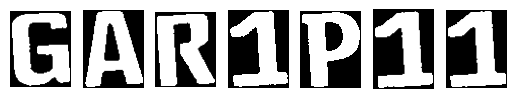

6AR1P11
179.JPG


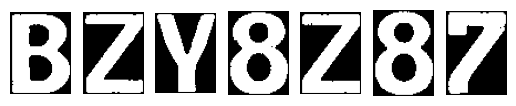

BZY8Z87
181.JPG


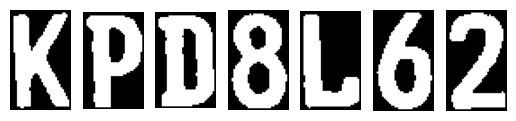

KPB8L62
182.JPG
131 19 42
['19.jpg', '30.JPG', '62.JPG', '64.JPG', '66.JPG', '77.jpg', '79.jpg', '87.JPG', '108.JPG', '110.JPG', '112.JPG', '117.JPG', '121.JPG', '122.JPG', '123.JPG', '125.JPG', '126.JPG', '127.JPG', '182.JPG']


In [282]:
ignoredIssues=[]
tAccuracy=0
with open("results.txt","w") as f:
    f.write('Car   Knn Result           Expected Result          accuracy \n')
    for car,car_file_name in cars.items():
        try:
            if car_file_name not in ignoreFromCropp:
                car_image = cv2.imread("./test_dataset/images/"+car_file_name)
                # show_images([car_image], ["Input Image"])
                print(car_file_name)
                cars_image_cropped = crop_image(car_image) 
                if len(cars_image_cropped)>0:
                    # show_images([cars_image_cropped] , ["Car Image Cropped"])
                    # car_image_rotated = rotate_image(cars_image_cropped)
                    # show_images([car_image_rotated] , ["Car Image Rotated"])

                    chars = segment_Character(cars_image_cropped)
                    # show_images(chars)
                    data2=""
                    # show_images(chars)
                    for img in chars:
                        # print(img)
                        new_img = cv.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv.INTER_AREA)
                        new_img = new_img.reshape((1,IMG_WIDTH*IMG_HEIGHT))
                        # print(new_img.shape)
                        y_prediction = knn_default.predict(new_img)
                        # print(digitLetter[int(y_prediction)])
                        data2+=digitLetter[int(y_prediction)]
                    print(data2)
                    editDistance = lev(data2, test_plates[car])
                    size = len(test_plates[car]) 
                    accuracy = ((size-editDistance)/size)*100
                    tAccuracy+=accuracy
                    # textWrite="Car "+car+" KNN Result "+data2+" Expected Result "+test_plates[car]+'\n'
                    textWrite=car+"     "+data2+"          "+test_plates[car]+"        "+str(accuracy)+'\n'
                    f.write(textWrite)
                else:
                    ignoreFromCropp.append(car_file_name)
        except IndexError:
            ignoredIssues.append(car_file_name)
            continue
    print(len(cars),len(ignoredIssues),len(ignoreFromCropp))
    ignoredLenth=len(cars)-(len(ignoredIssues)+len(ignoreFromCropp))
    f.write(str((tAccuracy/ignoredLenth)))

        
print(ignoredIssues)
        